# This is spectral density analayis notebook for 1ps sampling 

based on kcsa_Md_kwkw-opls5_1p_10ns_121924 trajactory
CSA orientation is extracted by notebook:[text](analysis/analysis_notebooks/spectral_density_fast_sampling_I.ipynb)
The output results is saved in :[text](analysis/results/kcsa_md_kwkw_opls5_1p_10ns_121924/kcsa_md_kwkw_opls5_1p_10ns_121924_CSA_orientations.npz)

In [30]:
# reload data
import numpy as np
import os

data_path = '~/Dropbox/KcsA/analysis/results/kcsa_md_kwkw_opls5_1p_10ns_121924/kcsa_md_kwkw_opls5_1p_10ns_121924_CSA_orientations.npz'
expanded_path = os.path.expanduser(data_path)  # Expands `~` to the full home directory path

try:
    data = np.load(expanded_path, allow_pickle=True)
    sigma_33_dict = data['sigma_33'].item()  # Use `.item()` to extract the dictionary
    sigma_22_dict = data['sigma_22'].item()
    sigma_11_dict = data['sigma_11'].item()
    print("Data loaded successfully!")
except FileNotFoundError as e:
    print(f"Error: {e}")


Data loaded successfully!


In [31]:
# calculat the euler angles of the CSA tensors

# singma_22_dict is the beta angle (distribution of beta angle)
# let's visualize the beta angle first
# calculate order parameters second


from scipy.spatial.transform import Rotation as R
import numpy as np

def calculate_euler_angles(ori_t, convention='ZYZ'):
    """
    Calculate Euler angles from orientation matrices.

    Parameters:
        ori_t (np.ndarray): Orientation matrices, shape (num_frames, num_residues, 3, 3).
        convention (str): Euler angle convention, e.g., 'ZYX', 'ZXZ', etc.

    Returns:
        np.ndarray: Euler angles, shape (num_frames, num_residues, 3) for yaw, pitch, roll.
    """
    num_frames, num_residues = ori_t.shape[:2]
    euler_angles = np.zeros((num_frames, num_residues, 3))
    
    for frame in range(num_frames):
        for residue in range(num_residues):
            # Extract the 3x3 rotation matrix for this frame and residue
            rotation_matrix = ori_t[frame, residue]
            # Convert to Euler angles
            euler_angles[frame, residue] = R.from_matrix(rotation_matrix).as_euler(convention, degrees=True)
    
    return euler_angles

ori_t={}
for chain in ['A', 'B', 'C', 'D']:
    # Stack the sigma arrays along the last axis
    ori_t[chain] = np.stack(
        (sigma_33_dict[chain], sigma_22_dict[chain], sigma_11_dict[chain]),
        axis=-1
    )  # frame, resi_num, 3, 3
    
euler_angles_A = calculate_euler_angles(ori_t['A'], convention='ZYZ')

print(euler_angles_A.shape)

(9982, 7, 3)


In [32]:
# proces for other chains
Euler={}
for chain in ['A','B', 'C', 'D']:
    Euler[f'euler_angles_{chain}'] = calculate_euler_angles(ori_t[chain], convention='ZYZ')

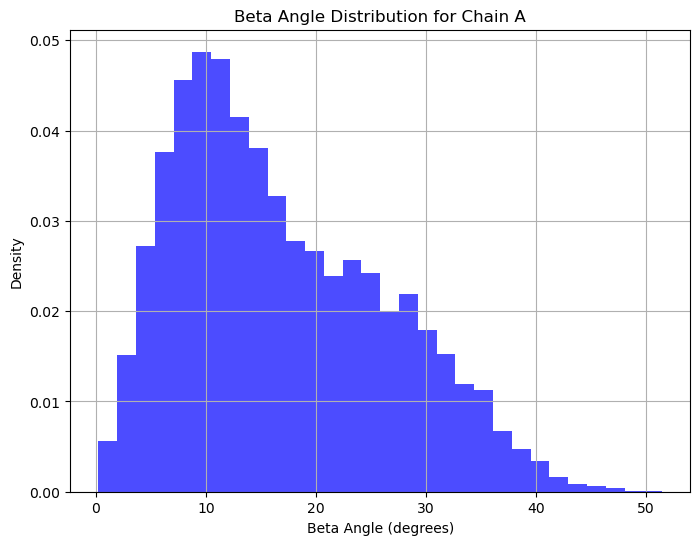

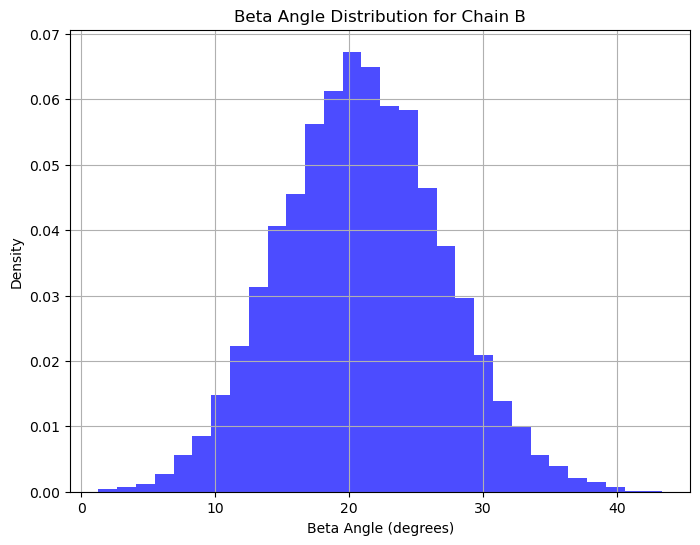

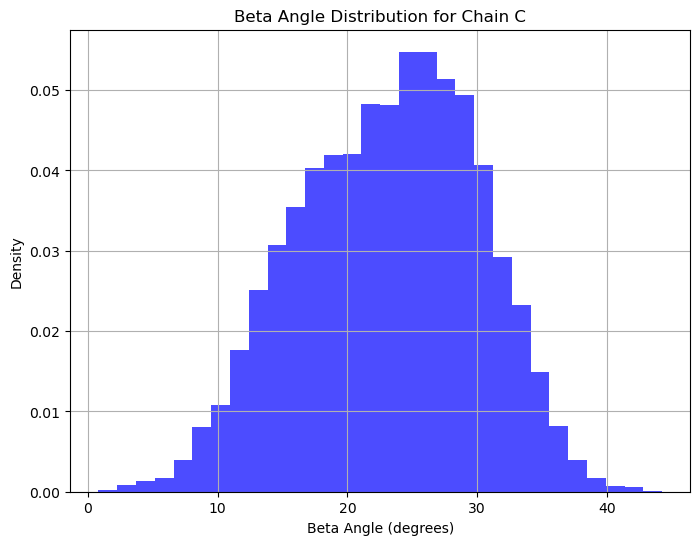

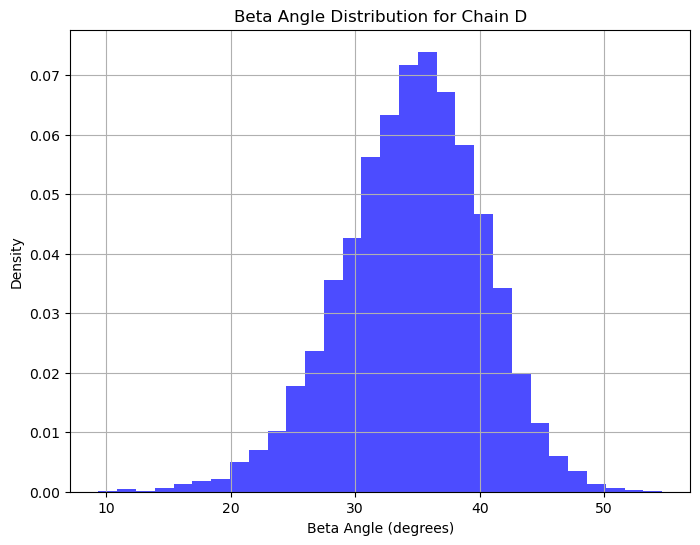

In [33]:
# visualize the beta angle distribution
import matplotlib.pyplot as plt

%matplotlib inline
def plot_beta_angle_distribution(beta_angles, chain):
    """
    Plot the distribution of beta angles.

    Parameters:
        beta_angles (np.ndarray): Beta angles for the specified chain.
        chain (str): Chain identifier.
    """
    plt.figure(figsize=(8, 6))
    plt.hist(beta_angles, bins=30, density=True, alpha=0.7, color='blue')
    plt.title(f'Beta Angle Distribution for Chain {chain}')
    plt.xlabel('Beta Angle (degrees)')
    plt.ylabel('Density')
    plt.grid()
    plt.show()

# Plot the beta angle distribution for each chain of V76
for chain in ['A', 'B', 'C', 'D']:
    beta_angles = Euler[f'euler_angles_{chain}'][:, 2, 1]  # Extract beta angles (index 1 for ZYZ convention)
    plot_beta_angle_distribution(beta_angles, chain)

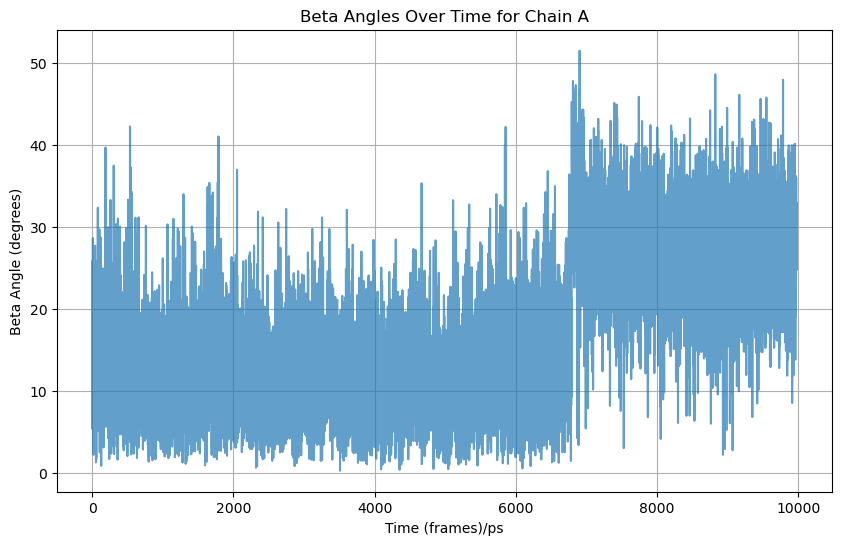

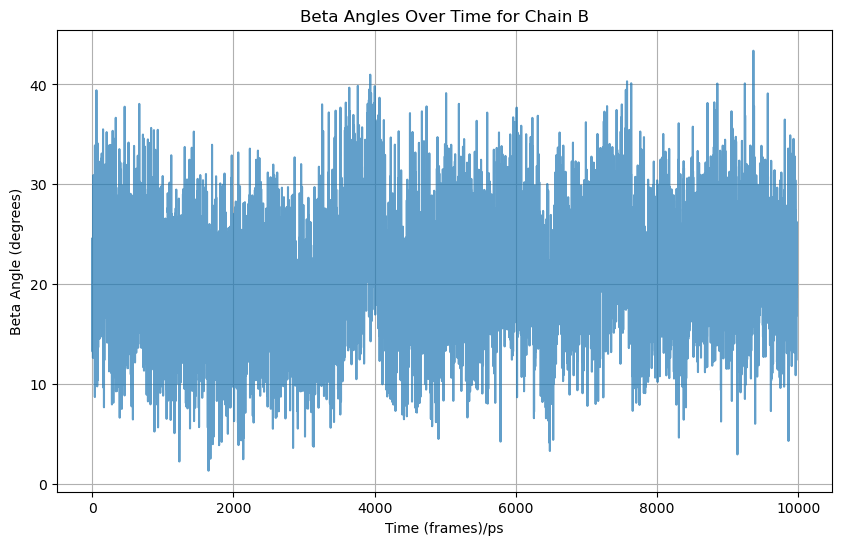

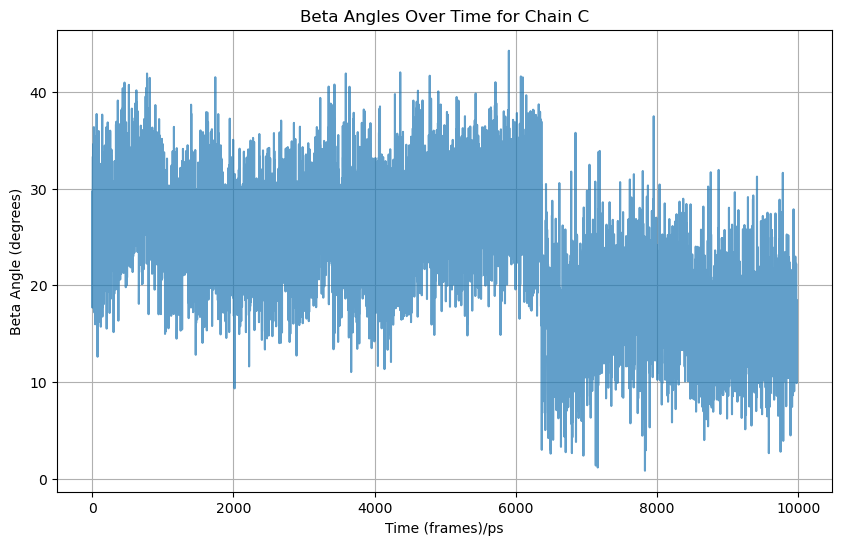

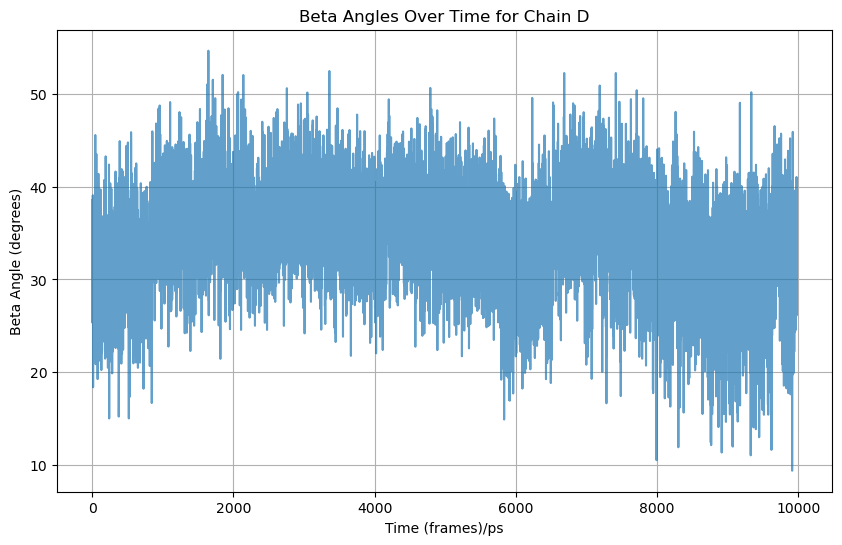

In [34]:
# visualize the beta angle over time
def plot_beta_angle_over_time(beta_angles, chain, time_step=1):
    """
    Plot the beta angles over time for a specified chain.

    Parameters:
        beta_angles (np.ndarray): Beta angles for the specified chain.
        chain (str): Chain identifier.
    """
    plt.figure(figsize=(10, 6))
    time = np.array(range(len(beta_angles))) * time_step # Assuming each frame corresponds to a time step
    plt.plot(time, beta_angles, alpha=0.7)
    plt.title(f'Beta Angles Over Time for Chain {chain}')
    plt.xlabel('Time (frames)/ps')
    plt.ylabel('Beta Angle (degrees)')
    plt.grid()
    plt.show()

# Plot the beta angle over time for each chain of V76
for chain in ['A', 'B', 'C', 'D']:
    beta_angles = Euler[f'euler_angles_{chain}'][:, 2, 1]  # Extract beta angles (index 1 for ZYZ convention)
    plot_beta_angle_over_time(beta_angles, chain, time_step=1)  # Assuming each frame corresponds to 10 ps

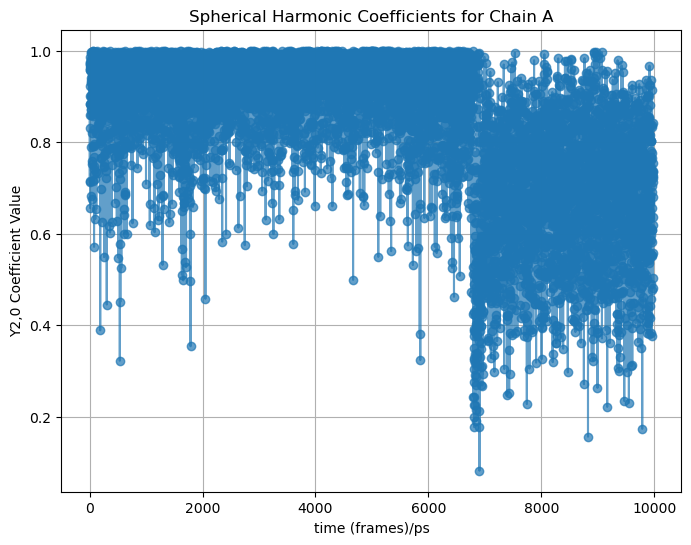

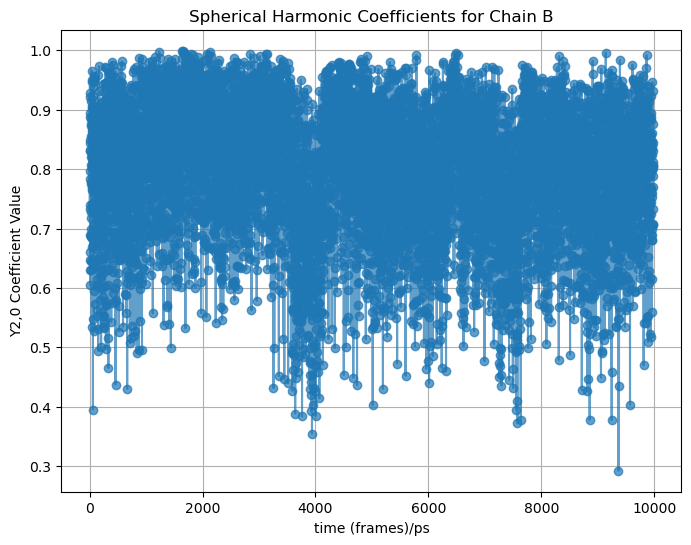

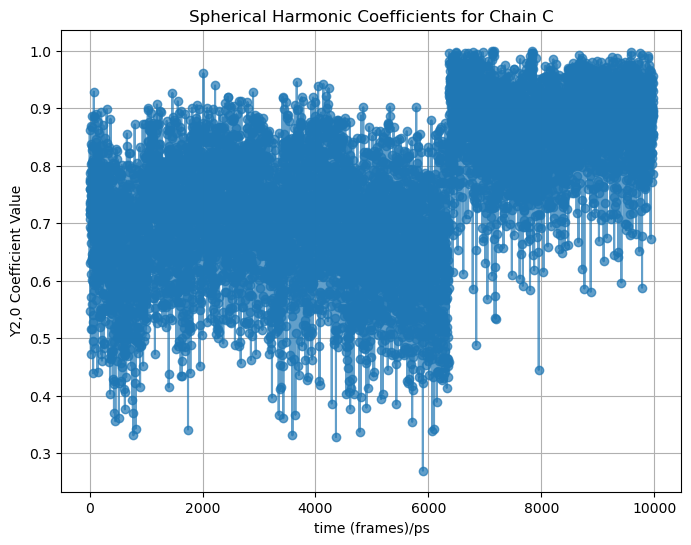

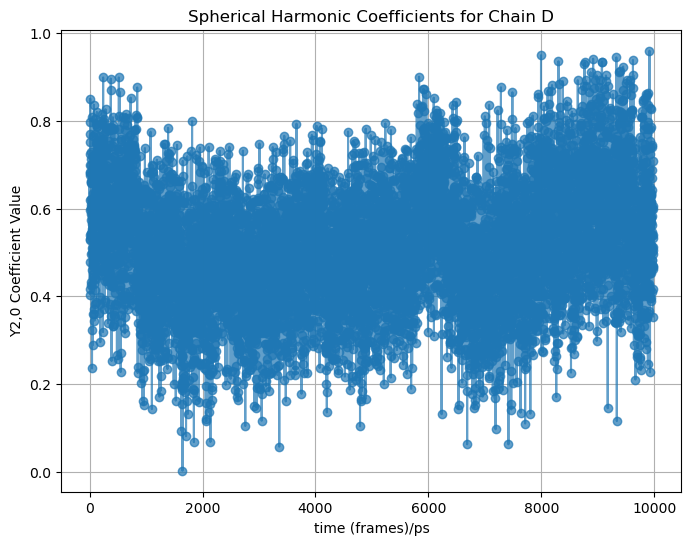

In [35]:
# plot the Y2,0 spherical harmonic coefficients
def plot_spherical_harmonic_coefficients(euler, chain,time_step=1):
    """
    Plot the spherical harmonic coefficients for a specified chain.

    Parameters:
        coefficients (np.ndarray): Spherical harmonic coefficients for the specified chain.
        chain (str): Chain identifier.
    """
    plt.figure(figsize=(8, 6))
    coefficients= 1/2*(3*np.cos(euler[f'euler_angles_{chain}'][:,2,1]/180*np.pi)**2-1)
    time = np.array(range(len(coefficients))) * time_step 
    plt.plot(time, coefficients, marker='o', linestyle='-', alpha=0.7)
    plt.title(f'Spherical Harmonic Coefficients for Chain {chain}')
    plt.xlabel('time (frames)/ps')
    plt.ylabel('Y2,0 Coefficient Value')
    plt.grid()
    plt.show()

# Plot the spherical harmonic coefficients for each chain of V76
for chain in ['A', 'B', 'C', 'D']:
    plot_spherical_harmonic_coefficients(Euler, chain, time_step=1)  # Assuming each frame corresponds to 10 ps

In [41]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


def block_analysis (euler, chain, index, block_size):
    """
    params:
    euler : dict
        Dictionary with chain IDs as keys and 3D numpy arrays as values.
        Each array has shape (num_frames, num_residues, 3), where the last
        dimension contains [yaw, pitch, roll] angles in degrees.
    chain : str
        Chain ID to process (e.g., 'A', 'B', etc.).
    index : int
        Index of the residue to analyze.
    block_size : int
        Size of each block for analysis.
    """
    # if chain not in euler[f'euler_angles_{chain}']:
    #     raise ValueError(f"Chain '{chain}' not found in euler_angles.")
    num_frames, num_residues=euler[f'euler_angles_{chain}'].shape[:2]
    num_blocks= int(num_frames/block_size)
    
    for i in range(num_blocks):
        start = i * block_size
        end = start + block_size
        if end > num_frames:
            end = num_frames
        # Extract the block of data for the specified residue
        block_data = euler[f'euler_angles_{chain}'][start:end, index, 1]
        # Calculate the autocorrelation function for the block and add it to the list
        if len(block_data) < 2:
            print(f"Block {i} is too small for autocorrelation calculation.")
            continue
        acf = autocorrelation_sphere20(block_data)
        if i == 0:
            acf_list = acf
        else:
            acf_list = np.vstack((acf_list, acf))
    # Calculate the average autocorrelation function across all blocks
    avg_acf = np.mean(acf_list, axis=0)
    # Plot the average autocorrelation function
    plt.figure(figsize=(10, 6))
    plt.plot(avg_acf, marker='o', linestyle='-', alpha=0.7)
    plt.title(f'Average Autocorrelation Function for Chain {chain}, Residue {index+74}')
    plt.xlabel('Lag (frames)')
    plt.ylabel('Autocorrelation')
    plt.grid()
    plt.show()
  
       
        

def autocorrelation_sphere20(euler_angles):
    """
    Calculate the autocorrelation function for the Y2,0 component of CSA interactions,
    computed individually for each residue.

    Parameters:
    -----------
    euler_angles : 
        numpy.ndarray
        Euler angles for the Y2,0 component, shape (num_frames).

    Returns:
    --------
    acf : numpy.ndarray
        Autocorrelation function for the Y2,0 component, with shape (num_frames - 1, num_residues).
    """
    # if chain not in euler_angles:
    #     raise ValueError(f"Chain '{chain}' not found in euler_angles.")

    # Extract pitch angle (beta) and calculate Y2,0 component
    beta = np.radians(euler_angles)  # Convert to radians
    cos_beta = np.cos(beta)  # Cosine of beta
    cos2 = cos_beta**2  # Squared cosine of beta
    A = (3 * cos2 - 1) / 2.0  # Y2,0 CSA interaction, shape: (num_frames, num_residues)
    #print(A.shape)

    # Calculate mean over frames for each residue
    A_mean = np.mean(A)  # Shape: (1, num_residues)
    epsilon=epsilon = 1e-10
    variance = np.var(A) + epsilon  # Variance with added epsilon
    #print(variance.shape)

    # Number of frames and residues
    num_frames = A.shape[0]

    # Preallocate autocorrelation array
    acf = np.zeros(int(num_frames/2))

    # Calculate ACF
#     for k in range(1, num_frames):  # Skip k=0 (full overlap)
#         # Mean-subtracted product for each residue
#         overlap = num_frames - k  # Overlapping frames
#         acf[k - 1] = np.sum(
#             (A[:-k] - A_mean) * (A[k:] - A_mean), axis=0
#         ) / overlap

        # Handle k = 0 separately
    # acf[0] = np.sum((A-A_mean)**2)/num_frames
        
    # for k in range(1, num_frames):  # Skip k=0 (full overlap)
    # # Mean-subtracted product for each residue
    #     overlap = num_frames - k  # Overlapping frames
    #     acf[k] = np.sum(
    #         (A[:-k] - A_mean) * (A[k:] - A_mean), axis=0
    #     ) / overlap

    
    # # Shape: (1, num_residues)
    # acf /= variance

    acf[0] = np.sum((A)**2)/num_frames
        
    for k in range(1, int(num_frames/2)):  # Skip k=0 (full overlap)
    # Mean-subtracted product for each residue
        overlap = num_frames - k  # Overlapping frames
        acf[k] = np.sum(
            (A[:-k] ) * (A[k:] ), axis=0
        ) / overlap

    
    # Shape: (1, num_residues)
    acf /= acf[0]  # Normalize by the first value (k=0)

    return acf

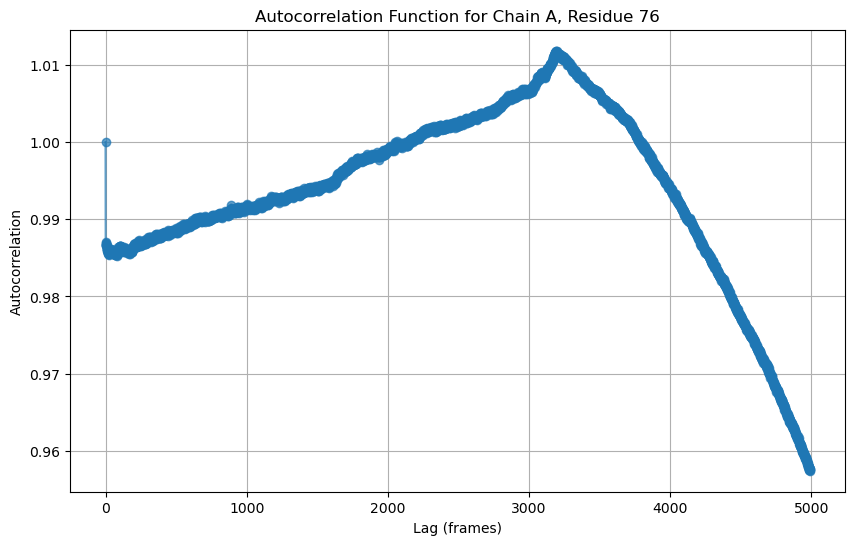

In [40]:
# test the block_analysis function

 # Analyze residue at index 2 for each chain

chain = 'A'  # Example chain
test=Euler[f'euler_angles_{chain}'][:,2,1]
acf = autocorrelation_sphere20(test)
# Plot the autocorrelation function
plt.figure(figsize=(10, 6))
plt.plot(acf, marker='o', linestyle='-', alpha=0.7)
plt.title(f'Autocorrelation Function for Chain {chain}, Residue 76')
plt.xlabel('Lag (frames)')
plt.ylabel('Autocorrelation')
plt.grid()
plt.show()

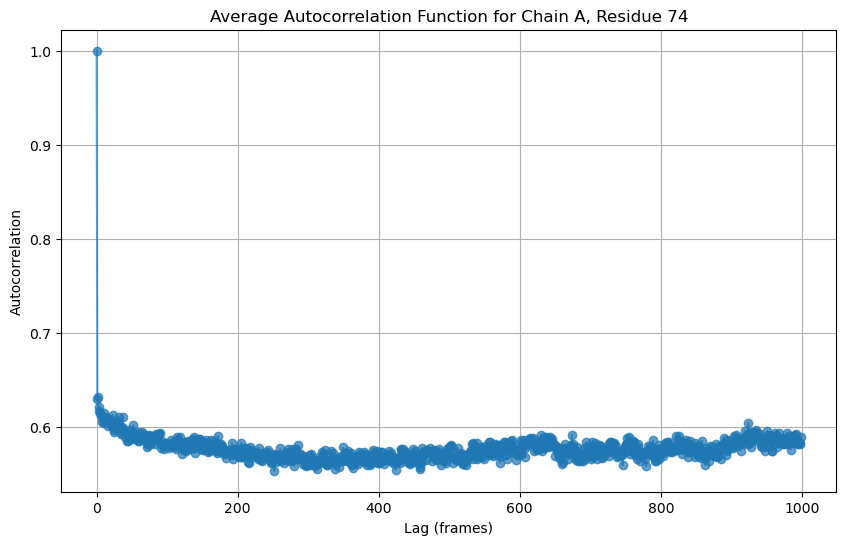

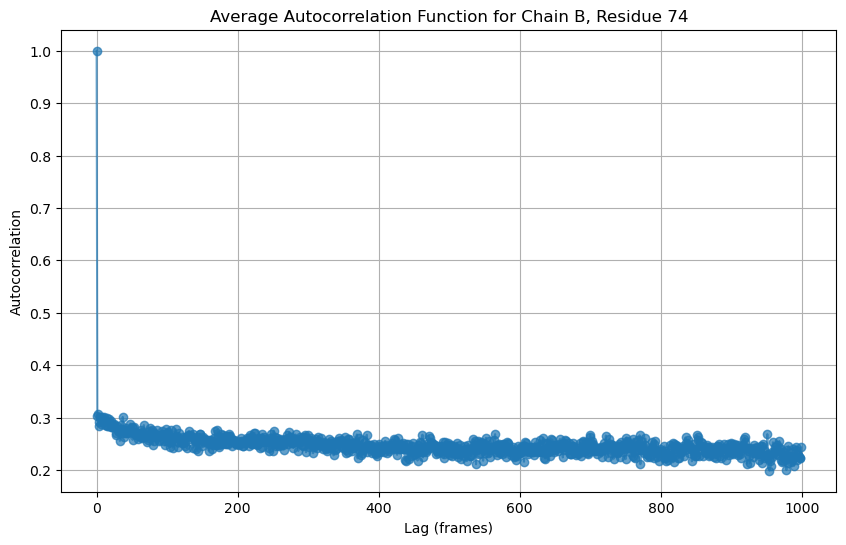

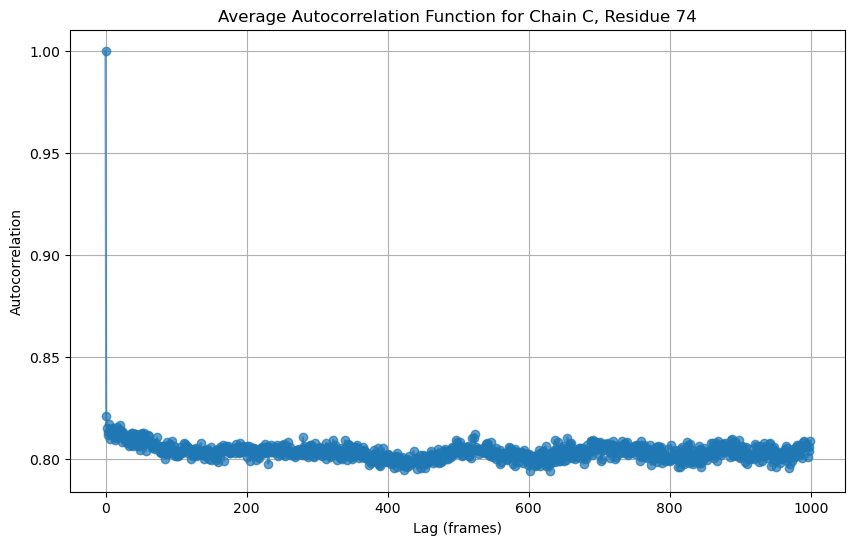

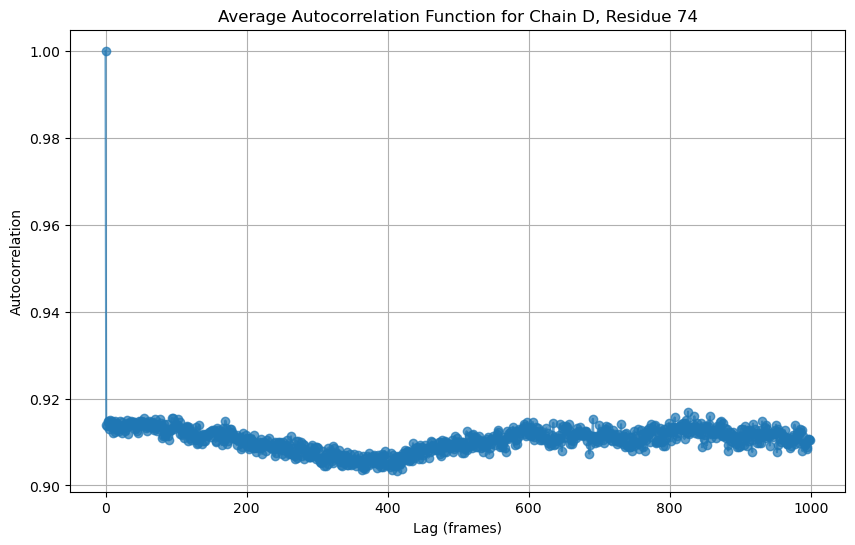

In [43]:
# block analysis
block_size = 2000  # Define the block size for analysis
for chain in ['A', 'B', 'C', 'D']:
    block_analysis(Euler, chain, index=0, block_size=block_size)  # Analyze residue at index 2 for each chain
#block_analysis(Euler, 'A', index=2, block_size=block_size)  # Analyze residue at index 2 for chain 'A'

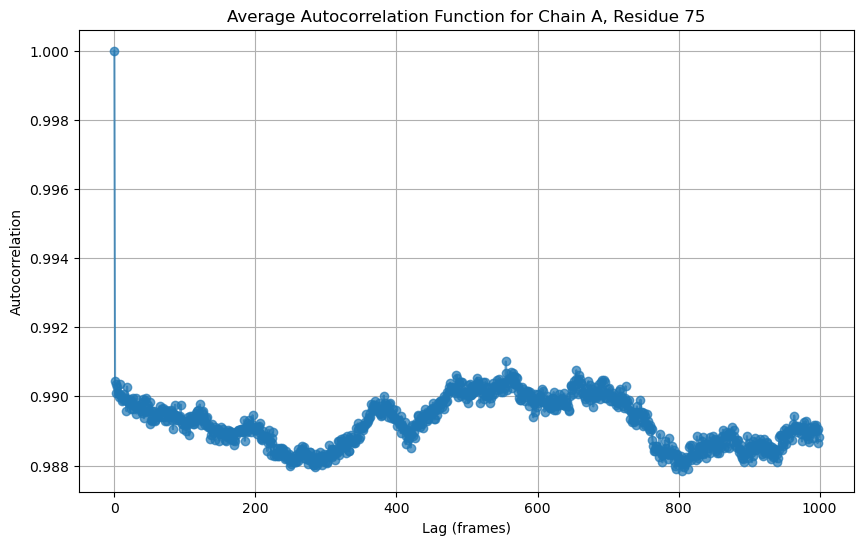

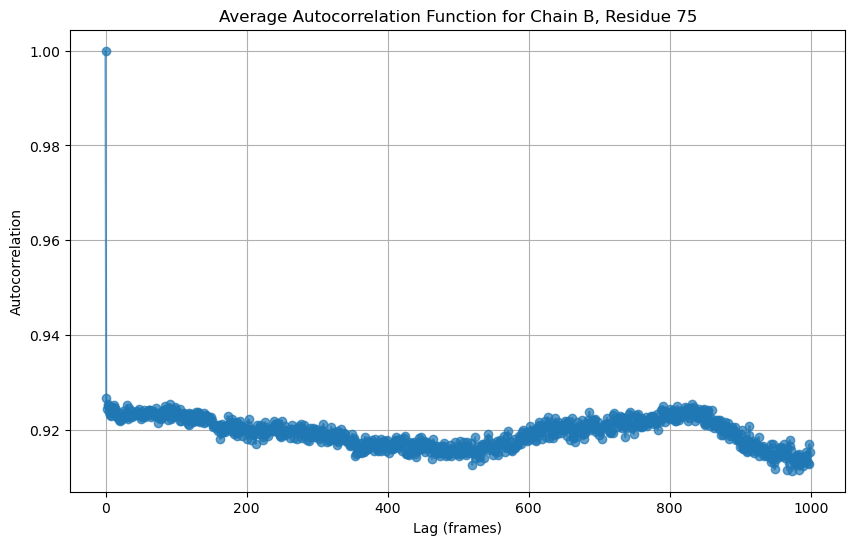

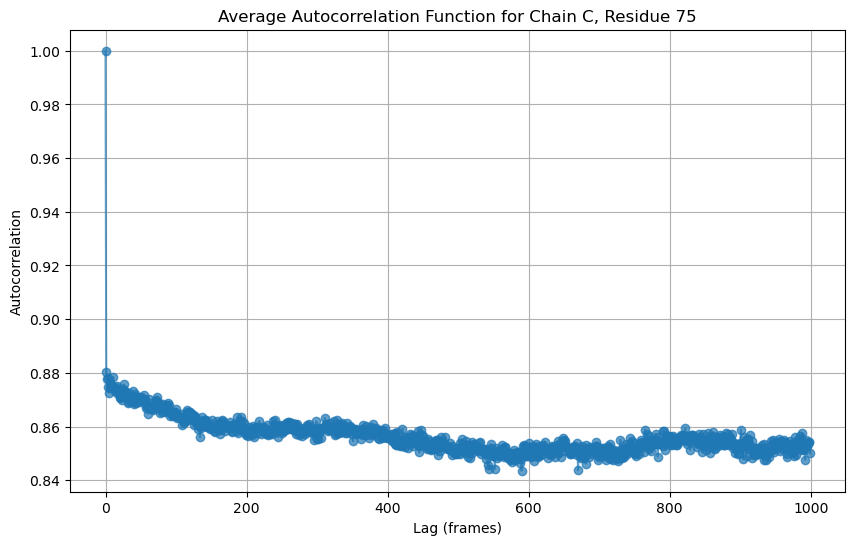

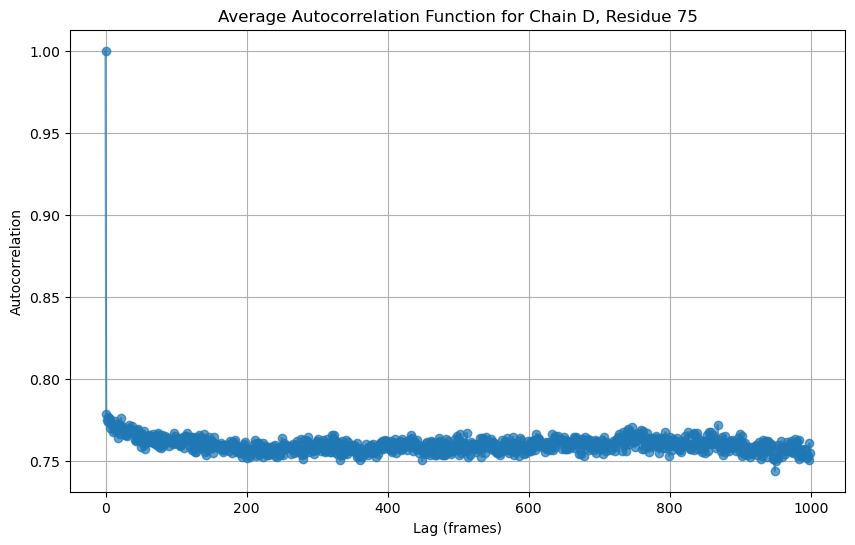

In [44]:
# block analysis
block_size = 2000  # Define the block size for analysis
for chain in ['A', 'B', 'C', 'D']:
    block_analysis(Euler, chain, index=1, block_size=block_size)  # Analyze residue at index 2 for each chain
#block_analysis(Euler, 'A', index=2, block_size=block_size)  # Analyze residue at index 2 for chain 'A'

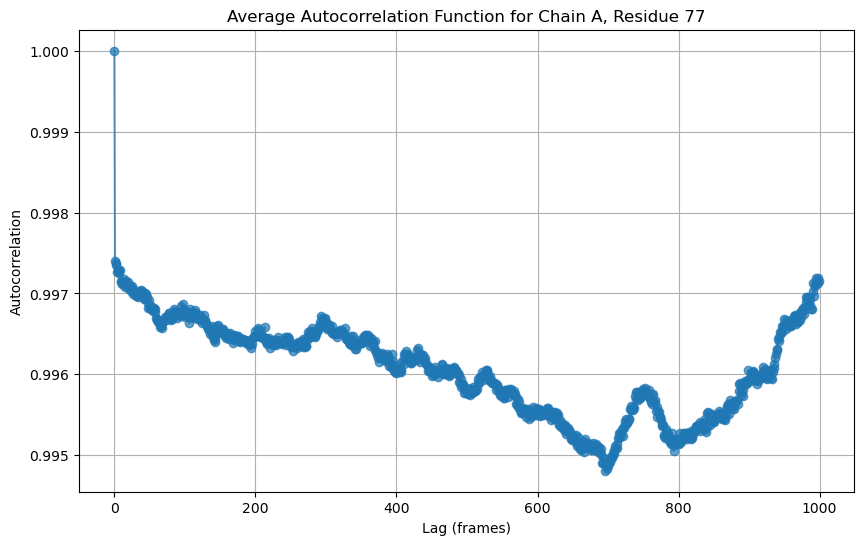

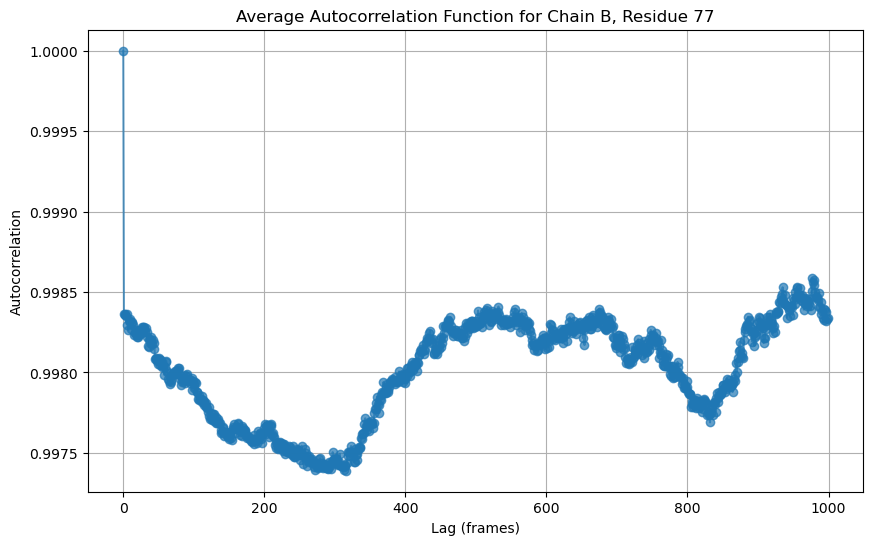

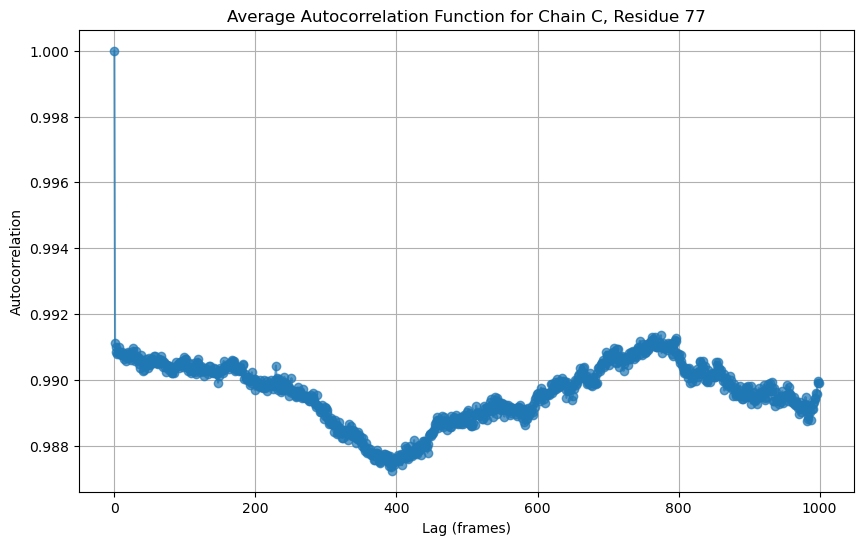

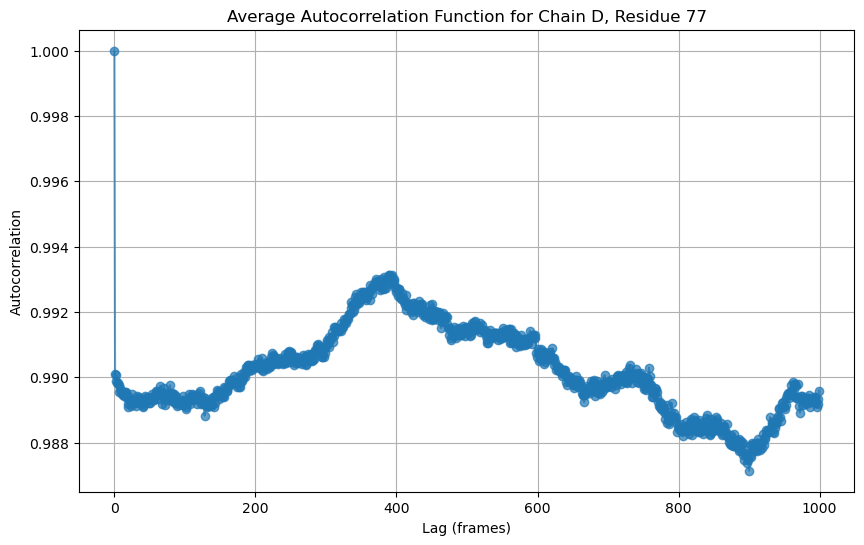

In [45]:
# block analysis
block_size = 2000  # Define the block size for analysis
for chain in ['A', 'B', 'C', 'D']:
    block_analysis(Euler, chain, index=3, block_size=block_size)  # Analyze residue at index 2 for each chain
#block_analysis(Euler, 'A', index=2, block_size=block_size)  # Analyze residue at index 2 for chain 'A'

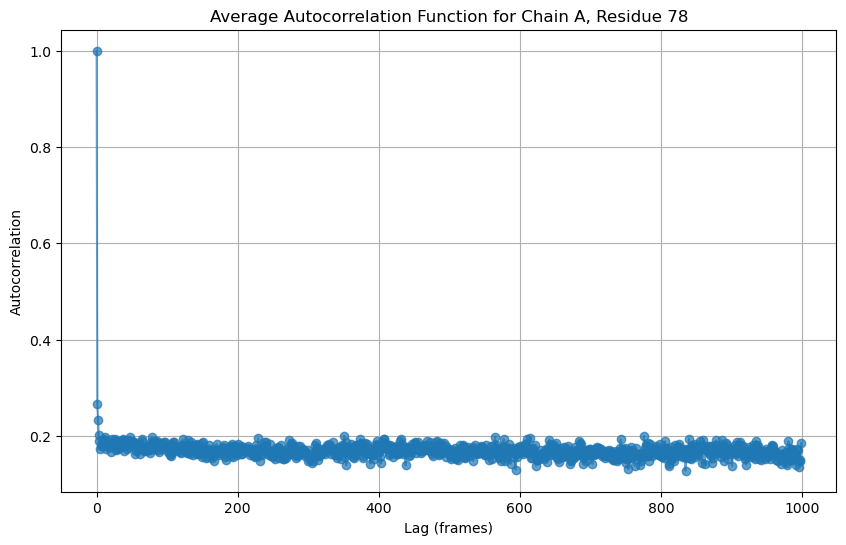

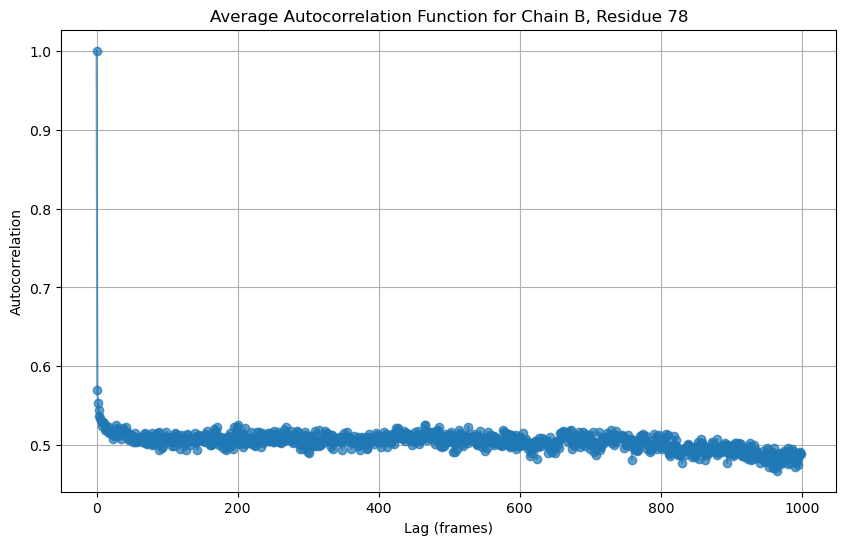

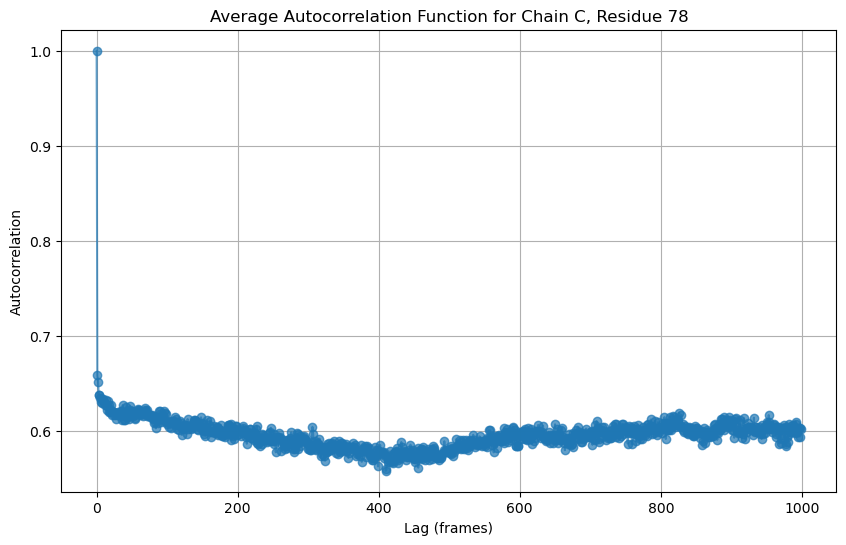

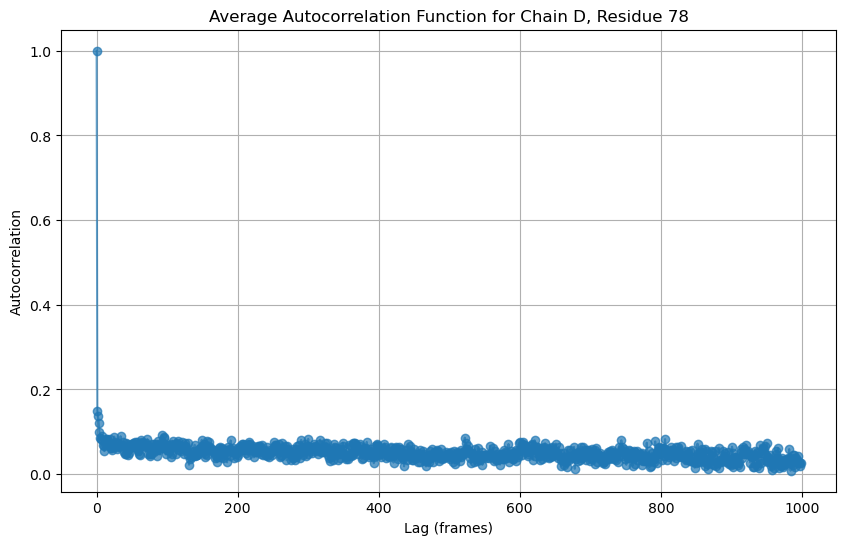

In [46]:
# block analysis
block_size = 2000  # Define the block size for analysis
for chain in ['A', 'B', 'C', 'D']:
    block_analysis(Euler, chain, index=4, block_size=block_size)  # Analyze residue at index 2 for each chain
#block_analysis(Euler, 'A', index=2, block_size=block_size)  # Analyze residue at index 2 for chain 'A'

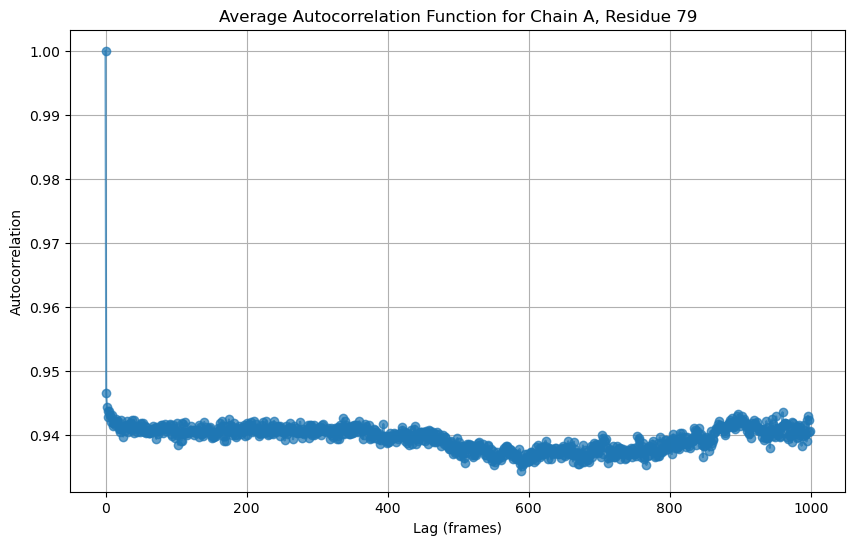

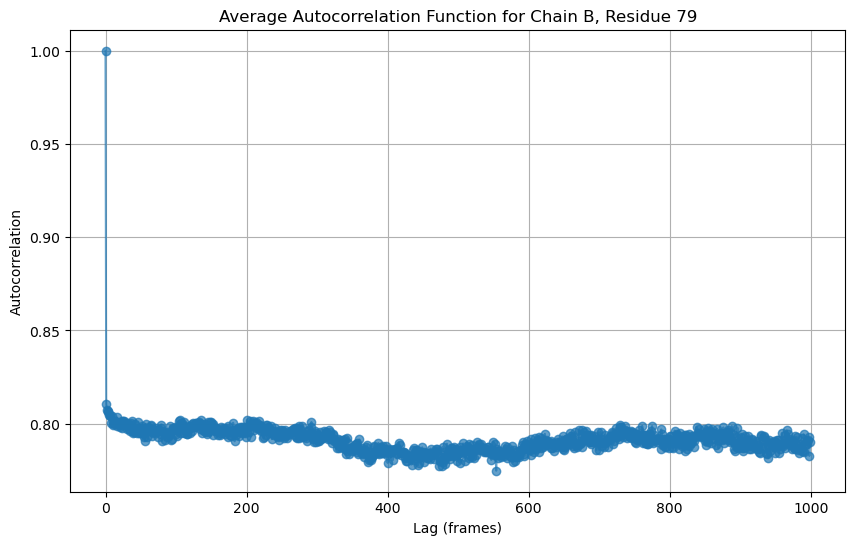

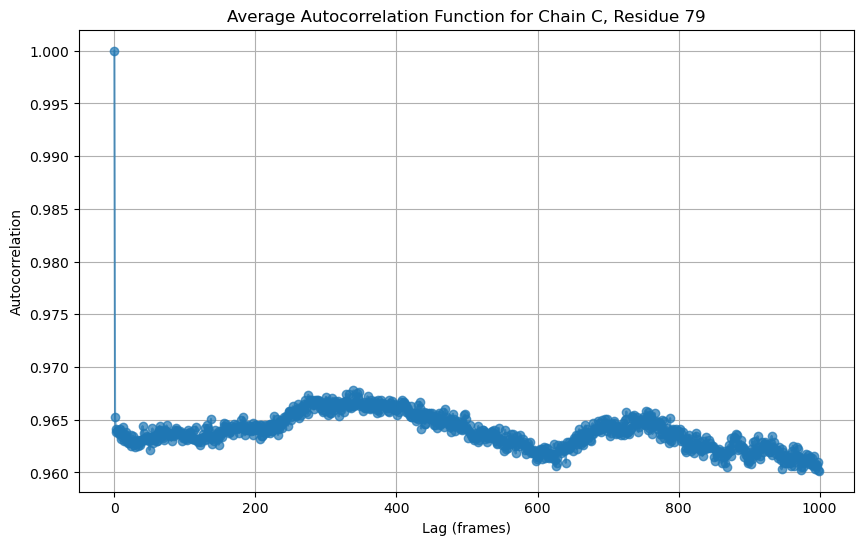

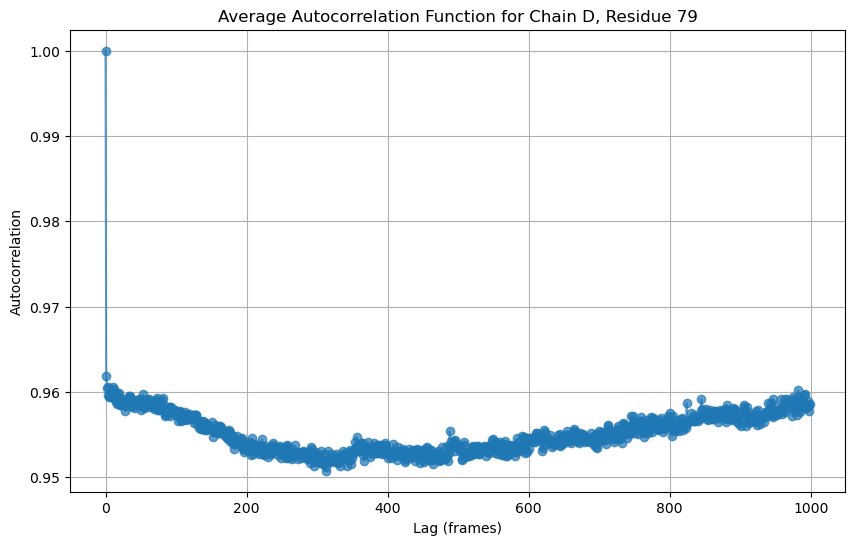

In [47]:
# block analysis
block_size = 2000  # Define the block size for analysis
for chain in ['A', 'B', 'C', 'D']:
    block_analysis(Euler, chain, index=5, block_size=block_size)  # Analyze residue at index 2 for each chain
#block_analysis(Euler, 'A', index=2, block_size=block_size)  # Analyze residue at index 2 for chain 'A'

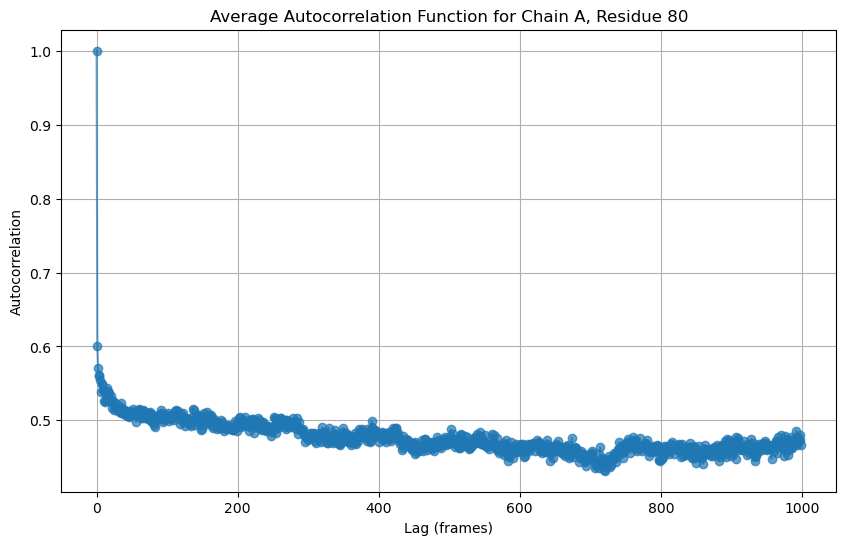

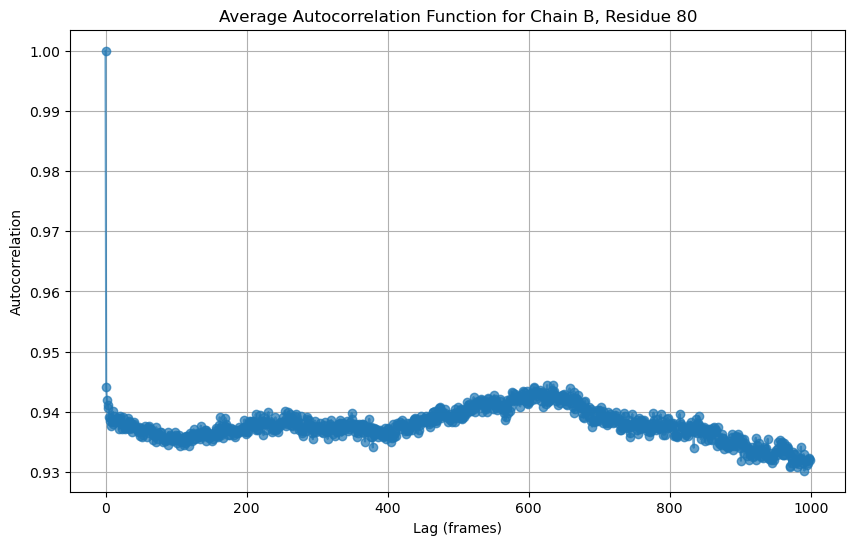

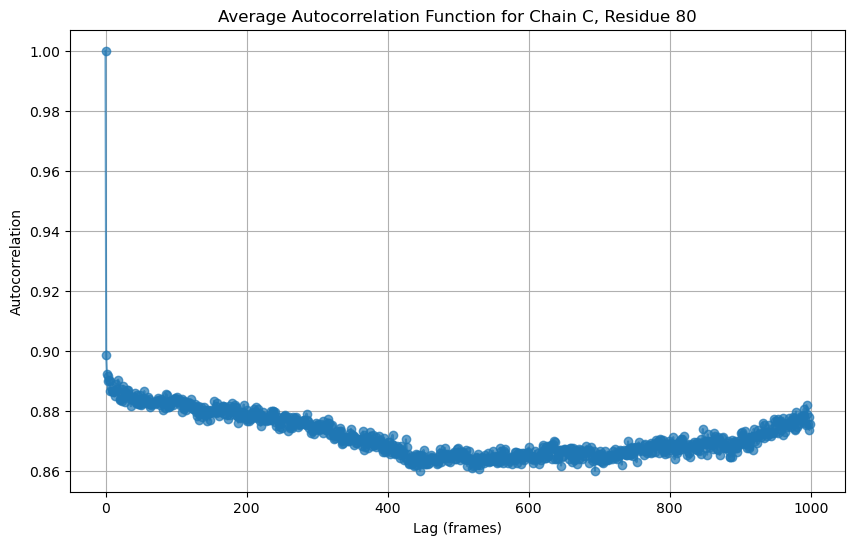

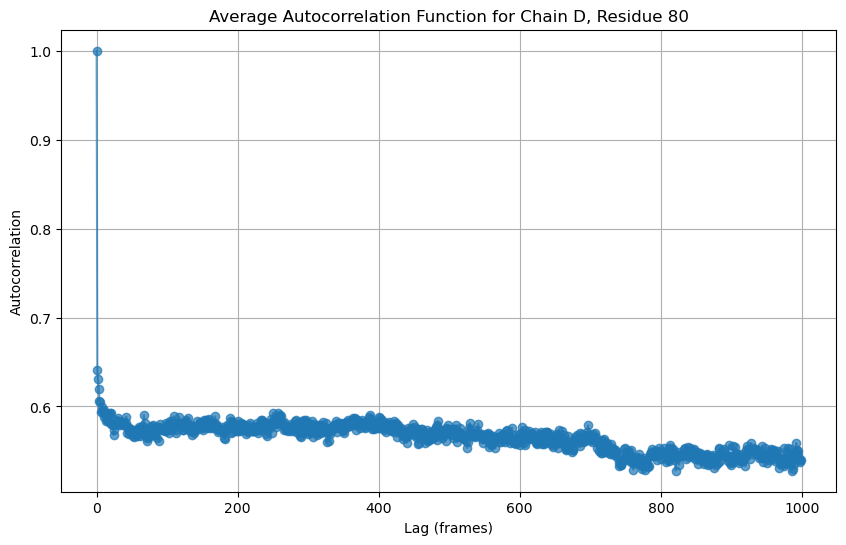

In [48]:
# block analysis
block_size = 2000  # Define the block size for analysis
for chain in ['A', 'B', 'C', 'D']:
    block_analysis(Euler, chain, index=6, block_size=block_size)  # Analyze residue at index 2 for each chain
#block_analysis(Euler, 'A', index=2, block_size=block_size)  # Analyze residue at index 2 for chain 'A'

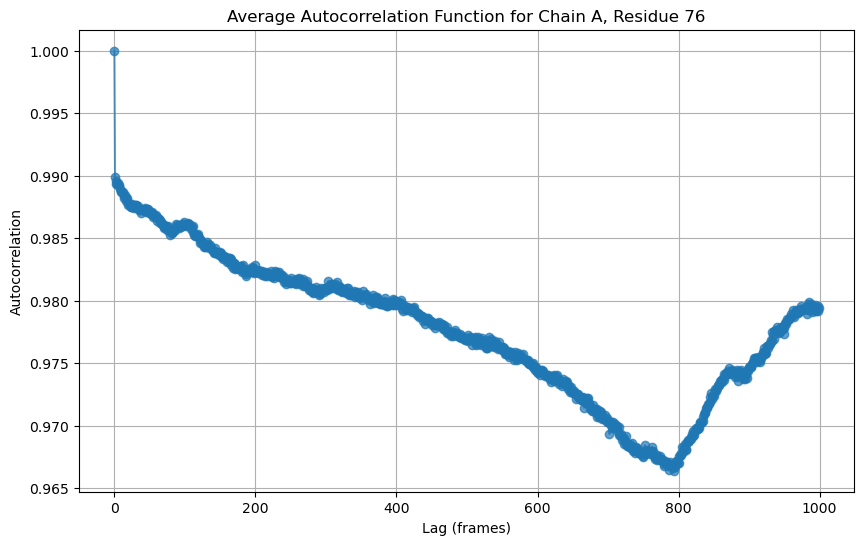

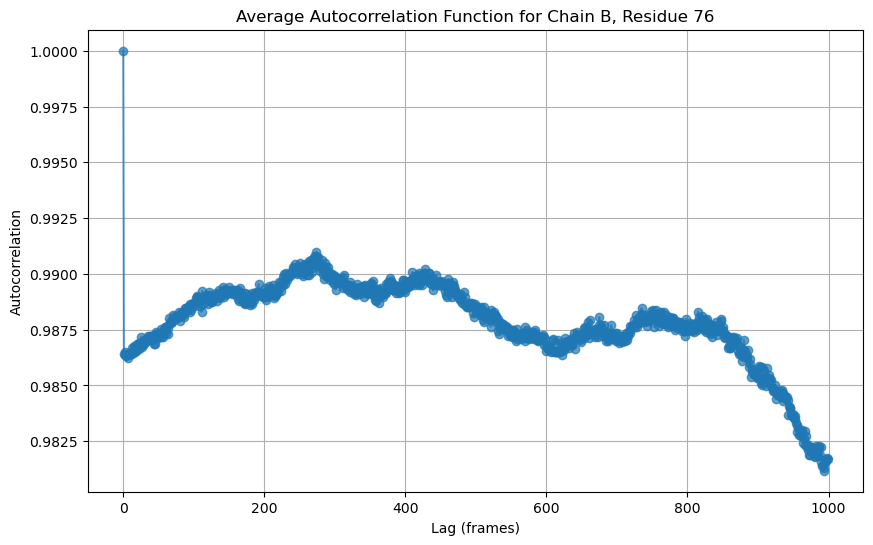

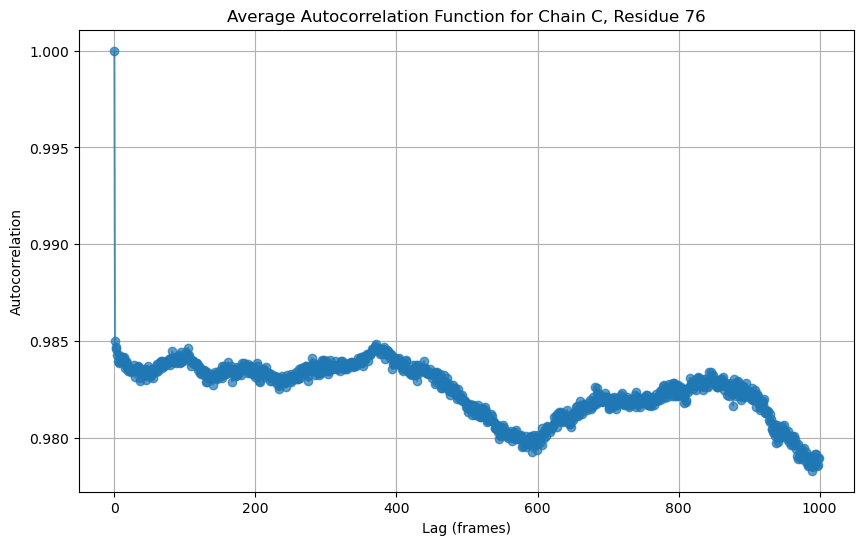

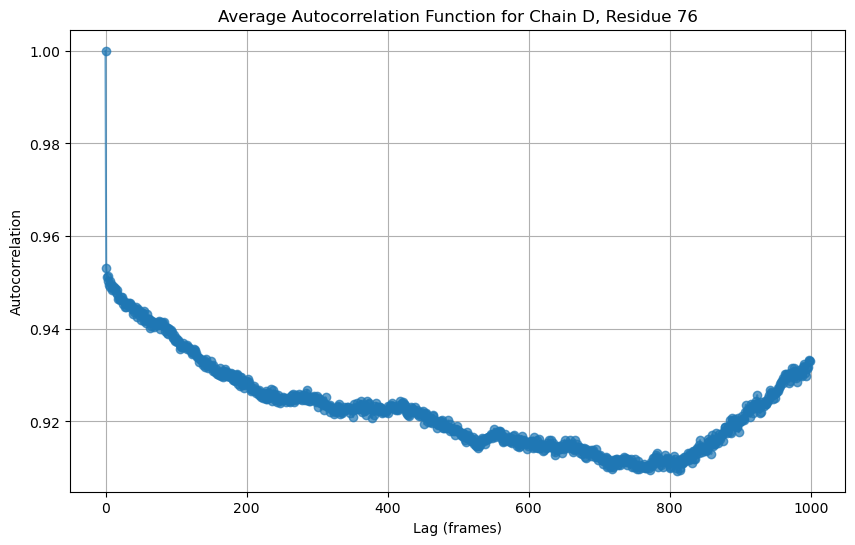

In [50]:
# block analysis
block_size = 2000  # Define the block size for analysis
for chain in ['A', 'B', 'C', 'D']:
    block_analysis(Euler, chain, index=2, block_size=block_size)  # Analyze residue at index 2 for each chain
#block_analysis(Euler, 'A', index=2, block_size=block_size)  # Analyze residue at index 2 for chain 'A'